100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


Text(0.5, 1.0, 'Signal')

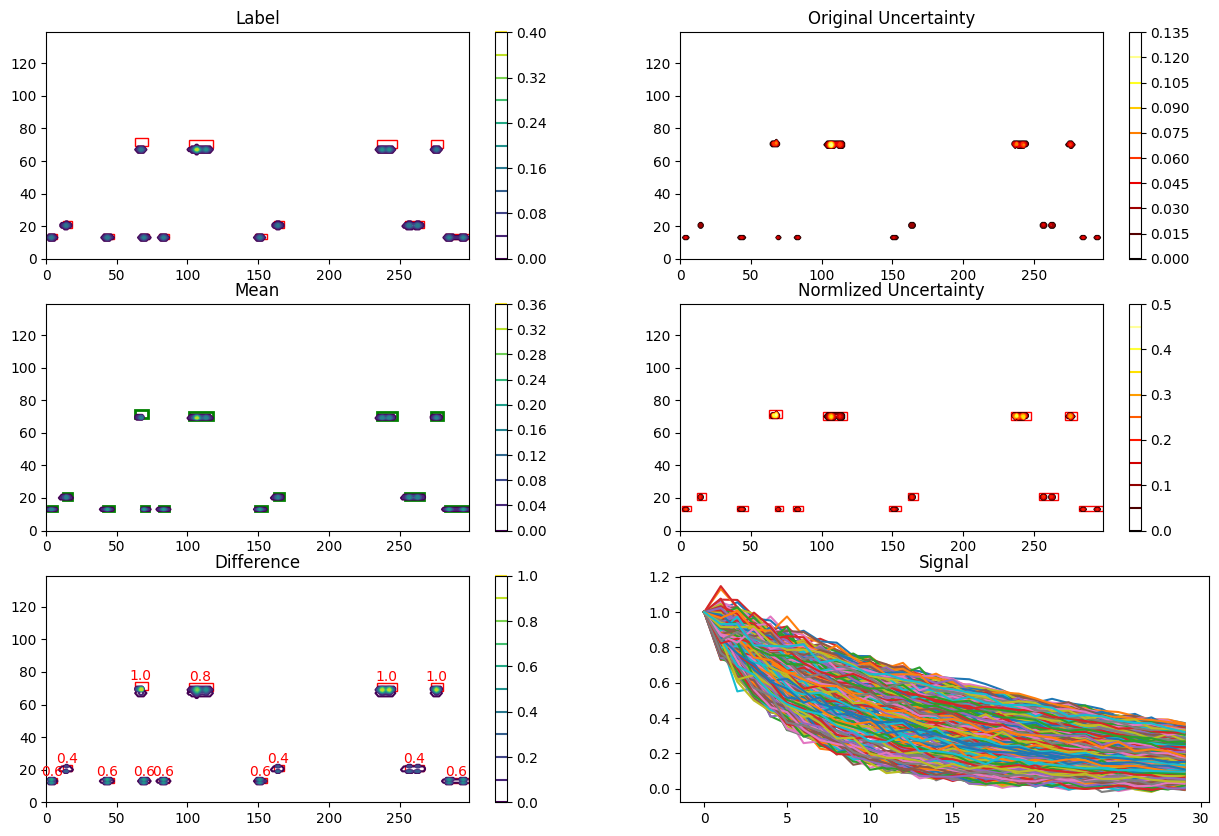

In [1]:
from matplotlib.patches import Rectangle
import config
import numpy as np
from post_process.find_peaks import calculate_difference_mean, find_box, normalize_matrix_with_max_values, show_box
import torch
import matplotlib.pyplot as plt
from model.model import DReaM_net
from dataset import gen_signal_dosy

np.random.seed(np.random.randint(1000))
DOSY_signal = gen_signal_dosy()
DOSY_signal.update_parameters(num_samples=1, o_fre=18, num_D=3, sig=0.1,sig_lorz=0.06, dB=27)
test_input, labels, cif = DOSY_signal.gen_signal_2D()
with torch.no_grad():
    module = DReaM_net.load_from_checkpoint("Result/DOSY/epoch=60-step=34343-v4.ckpt")
    module.prepare_for_testing()

def apply_dropout(m):
    if type(m) == torch.nn.Dropout:
        m.train()

test_input = torch.tensor(test_input)
test_input = test_input.to(torch.float32)
test_out, var = module(test_input)
var = torch.sqrt(var)
Cif_sum = cif.sum(1)[:, :, np.newaxis]
Cif_sum = Cif_sum/np.max(Cif_sum,axis=1,keepdims=True)

var = var * Cif_sum/config.mul_label
var = var[0].cpu().detach().numpy()

test_out = test_out * Cif_sum/config.mul_label
test_out = test_out[0].cpu().detach().numpy()
test_out[test_out < np.tile(((np.max(test_out, axis=1)) * 0.7)[:, np.newaxis], [1, module.hparams.label_size])] = 0
test_out[test_out < np.max(test_out)*0.1] = 0

var[var < np.tile(((np.max(var, axis=1)) * 0.7)[:, np.newaxis], [1, module.hparams.label_size])] = 0
var[var < np.max(var)*0.2] = 0

labels = (labels*Cif_sum).squeeze(0)/config.mul_label
labels[labels < np.max(labels)*0.1] = 0

merged_boxes = find_box(var.T)
norm_diff = normalize_matrix_with_max_values(test_out.T, np.abs(labels.T - test_out.T), merged_boxes, Cif_sum[0])
diff_mean_list = calculate_difference_mean(norm_diff, merged_boxes)
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

contour1 = axs[0, 0].contour(labels.T, levels=10)
fig.colorbar(contour1, ax=axs[0, 0])
axs[0, 0].set_title('Label')
show_box(axs[0, 0], merged_boxes)

contour2 = axs[1, 0].contour(test_out.T, levels=10)
fig.colorbar(contour2, ax=axs[1, 0])
axs[1, 0].set_title('Mean')

contour4 = axs[2, 0].contour(norm_diff, levels=10)
fig.colorbar(contour4, ax=axs[2, 0])
axs[2, 0].set_title('Difference')

for (bb, diff) in zip(merged_boxes, diff_mean_list):
        (x1, y1), (x2, y2) = bb
        width = x2 - x1 + 1
        height = y2 - y1 + 1
        rect = Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axs[2, 0].add_patch(rect)
        axs[2, 0].text((x1 + x2) / 2, y2 + 0.5, f"{diff:.1f}", ha='center', va='bottom', color='r')

contour5 = axs[0, 1].contour(var.T, cmap="hot", levels=10)
fig.colorbar(contour5, ax=axs[0, 1])
axs[0, 1].set_title('Original Uncertainty')
norm_var = normalize_matrix_with_max_values(test_out.T, var.T, merged_boxes, Cif_sum[0])
diff_mean_list = calculate_difference_mean(norm_var, merged_boxes)
for (bb, diff) in zip(merged_boxes, diff_mean_list):
    (x1, y1), (x2, y2) = bb
    width = x2 - x1 + 1
    height = y2 - y1 + 1
    
    if diff <= 0.5:
        color = 'g'
    else:
        color = 'r'

    rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
    axs[1, 0].add_patch(rect)

contour3 = axs[1, 1].contour(norm_var, cmap="hot", levels=10)
fig.colorbar(contour3, ax=axs[1, 1])
axs[1, 1].set_title('Normlized Uncertainty')
show_box(axs[1, 1], merged_boxes)

test_input = test_input[0]/test_input[0,:,0:1]
contour4 = axs[2, 1].plot(test_input.T)
axs[2, 1].set_title('Signal')

In [2]:
import config
import numpy as np
from post_process.find_peaks import process_samples
import torch
import matplotlib.pyplot as plt
from model.model import Transformer
from dataset import gen_signal_dosy

np.random.seed(2)
num_samples = 300
num_noise = 3

test_input = np.zeros((num_samples*num_noise, config.n_fre, config.signal_dim))
labels = np.zeros((num_samples*num_noise, config.n_fre, config.label_size))
cif = np.zeros((num_samples*num_noise, 3, config.n_fre))

for i in range(num_noise):
    DOSY_signal = gen_signal_dosy()
    DOSY_signal.update_parameters(num_samples=num_samples, o_fre=18, num_D=3, sig=0.1,sig_lorz=0.06, dB=30-5*i)
    test_input[i*num_samples:(i+1)*num_samples], labels[i*num_samples:(i+1)*num_samples], cif[i*num_samples:(i+1)*num_samples] = DOSY_signal.gen_signal_2D()

with torch.no_grad():
    module = DReaM_net.load_from_checkpoint("Result/DOSY/epoch=60-step=34343-v4.ckpt")
    module.prepare_for_testing()

test_input = torch.tensor(test_input)
test_input = test_input.to(torch.float32)
test_out, var = module(test_input)
var = torch.sqrt(var)
Cif_sum = cif.sum(1)[:, :, np.newaxis]
Cif_sum = Cif_sum/np.max(Cif_sum,axis=1,keepdims=True)

var = var * Cif_sum/config.mul_label
test_out = test_out * Cif_sum/config.mul_label
labels = labels *Cif_sum/config.mul_label
diff = torch.abs(test_out-labels)

Var = var.cpu().detach().numpy().copy()
Test_out = test_out.cpu().detach().numpy().copy()
Diff = diff.cpu().detach().numpy().copy()

peak_max_list1, uncertainty_max_list1, diff_max_list1 = process_samples(0, num_samples, Var, Test_out, Diff, labels, module)
peak_max_list2, uncertainty_max_list2, diff_max_list2 = process_samples(num_samples, 2*num_samples, Var, Test_out, Diff, labels, module)
peak_max_list3, uncertainty_max_list3, diff_max_list3 = process_samples(2*num_samples, 3*num_samples, Var, Test_out, Diff, labels, module)

100%|██████████| 300/300 [00:00<00:00, 2127.67it/s]


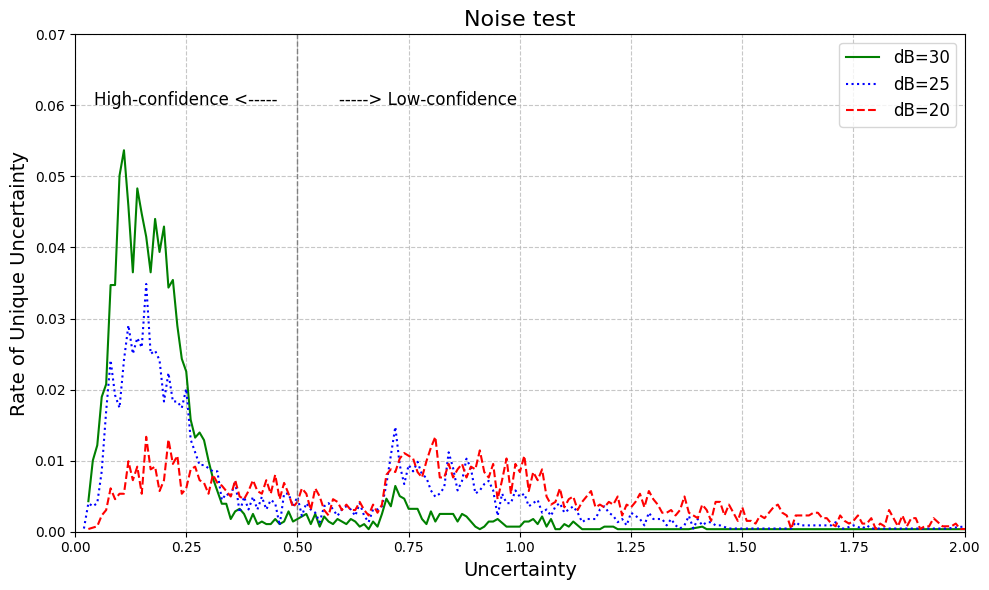

In [3]:
# Your existing function
def value_rate(diff_max, peak_max, uncertainty_max):
    idx = peak_max != 0
    diff_max, peak_max, uncertainty_max = diff_max[idx], peak_max[idx], uncertainty_max[idx]
    norm_var = uncertainty_max / peak_max
    norm_var = np.round(norm_var, 2)
    unique_values, counts = np.unique(norm_var, return_counts=True)
    rate = counts / np.sum(counts)
    return unique_values, rate, norm_var, diff_max

# Plot
plt.figure(figsize=(10, 6))
unique_values1, counts1, norm_var1, diff_max_list1 = value_rate(diff_max_list1, peak_max_list1, uncertainty_max_list1)
plt.plot(unique_values1, counts1, label='dB=30', color='g', linestyle='-')

unique_values2, counts2, norm_var2, diff_max_list2 = value_rate(diff_max_list2, peak_max_list2, uncertainty_max_list2)
plt.plot(unique_values2, counts2, label='dB=25', color='b', linestyle=':')

unique_values3, counts3, norm_var3, diff_max_list3 = value_rate(diff_max_list3, peak_max_list3, uncertainty_max_list3)
plt.plot(unique_values3, counts3, label='dB=20', color='r', linestyle='--')

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1)
plt.text(0.25, 0.06, 'High-confidence <-----', horizontalalignment='center', color='black', fontsize=12)
plt.text(0.8, 0.06, '-----> Low-confidence ', horizontalalignment='center', color='black', fontsize=12)

plt.xlim(0, 2)
plt.ylim(0, 0.07)
plt.xlabel("Uncertainty", fontsize=14)
plt.ylabel("Rate of Unique Uncertainty", fontsize=14)
plt.title("Noise test", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()


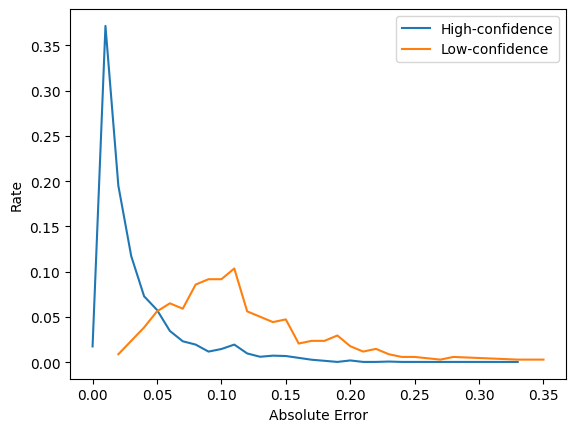

In [4]:
def count_values(arr):
    return np.unique(arr, return_counts=True)

norm_var = norm_var1
indexes = {
    "Low-confidence": np.where((norm_var >= 0.5) & (~np.isnan(norm_var)))[0],
    "High-confidence": np.where((norm_var < 0.5) & (~np.isnan(norm_var)))[0],
}

Diff = diff_max_list1
Diff = np.round(Diff, 2)

for key in ["High-confidence", "Low-confidence"]:
    unique_values, counts = count_values(Diff[indexes[key]])
    counts = counts/np.sum(counts)
    plt.plot(unique_values, counts, label=key)

# plt.xlim(0, 1)
plt.xlabel("Absolute Error")
plt.ylabel("Rate")
plt.legend()
plt.show()
